# Import libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product as itp
from copy import deepcopy

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from prophet import Prophet

from external_factors_functions import generate_custom_events_series
from utils import suppress_stdout_stderr

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('prophet').setLevel(logging.WARNING)

logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

pd.options.display.max_columns = None

Importing plotly failed. Interactive plots will not work.


In [2]:
train_table_path = "data/target_data.csv"
events_table_path = "data/holidays_US.csv"
output_table_path = "data/contextual_factors.csv"

models_path = "models/"
images_path = "images/"

timestep_frequency = "W-MON"

train_start = "2017/01/09"
train_end = "2022/12/31"
forecast_end = "2023/12/31"

# Parameters

In [3]:
# Prophet parameters to stay fix
prophet_fix_params = {
    "growth": "linear",
    "changepoint_range": 0.85,
    "weekly_seasonality": False,
    "daily_seasonality": False,
    "holidays_prior_scale": 10,
    "seasonality_prior_scale": 10
}

# Prophet parameters for cross-validation
prophet_cv_params = {
    "yearly_seasonality": [1, 2],
    "changepoint_prior_scale": [0.01, 0.05]
}


# Parameters of reference for each holiday, based on the correlations seen on the plots in the data visualition segment.
events_series_base_params = {
    "Super Bowl": {
        "delta_days_peak_effect": -1,
        "delta_time_steps_before_peak": 1,
        "delta_time_steps_after_peak": 0,
        "curve_std_idx": 0
    },
    "Valentine's Day": {
        "delta_days_peak_effect": -1,
        "delta_time_steps_before_peak": 1,
        "delta_time_steps_after_peak": 0,
        "curve_std_idx": 1
    },
    "St Patrick's Day": {
        "delta_days_peak_effect": -1,
        "delta_time_steps_before_peak": 1,
        "delta_time_steps_after_peak": 0,
        "curve_std_idx": 0
    },
    "Easter Sunday": {
        "delta_days_peak_effect": -1,
        "delta_time_steps_before_peak": 2,
        "delta_time_steps_after_peak": 0,
        "curve_std_idx": 1
    },
    "Cinco de Mayo": {
        "delta_days_peak_effect": -1,
        "delta_time_steps_before_peak": 2,
        "delta_time_steps_after_peak": 0,
        "curve_std_idx": 1
    },
    "Mother's Day": {
        "delta_days_peak_effect": -1,
        "delta_time_steps_before_peak": 1,
        "delta_time_steps_after_peak": 0,
        "curve_std_idx": 1
    },
    "Memorial Day": {
        "delta_days_peak_effect": -1,
        "delta_time_steps_before_peak": 1,
        "delta_time_steps_after_peak": 0,
        "curve_std_idx": 0
    },
    "Father's Day": {
        "delta_days_peak_effect": -1,
        "delta_time_steps_before_peak": 1,
        "delta_time_steps_after_peak": 0,
        "curve_std_idx": 1
    },
    "Independence Day": {
        "delta_days_peak_effect": -1,
        "delta_time_steps_before_peak": 1,
        "delta_time_steps_after_peak": 0,
        "curve_std_idx": 0
    },
    "Labor Day": {
        "delta_days_peak_effect": -1,
        "delta_time_steps_before_peak": 1,
        "delta_time_steps_after_peak": 0,
        "curve_std_idx": 0
    },
    "Halloween": {
        "delta_days_peak_effect": -1,
        "delta_time_steps_before_peak": 1,
        "delta_time_steps_after_peak": 0,
        "curve_std_idx": 0
    },
    "Thanksgiving": {
        "delta_days_peak_effect": -1,
        "delta_time_steps_before_peak": 2,
        "delta_time_steps_after_peak": 0,
        "curve_std_idx": 1
    },
    "Christmas Eve": {
        "delta_days_peak_effect": -1,
        "delta_time_steps_before_peak": 2,
        "delta_time_steps_after_peak": 0,
        "curve_std_idx": 1
    },
    "New Year's Eve": {
        "delta_days_peak_effect": -1,
        "delta_time_steps_before_peak": 2,
        "delta_time_steps_after_peak": 0,
        "curve_std_idx": 1
    }
}

# Values that can be added to the reference value during cross-validation
event_params_cv_ranges = {
    "delta_days_peak_effect_supp": [-2, -1, 0, 1],
    "delta_time_steps_before_peak_supp": [0, 1],
    "delta_time_steps_after_peak_supp": [0, 1],
    "curve_std_idx_supp": [-1, 0, 1],
}

In [4]:
df_target = pd.read_csv(train_table_path)

print(df_target.shape)
df_target.head(10)

(312, 2)


,ds,y
0,2017/01/09,3395140.55
1,2017/01/16,3501815.33
2,2017/01/23,3387375.15
3,2017/01/30,4134745.63
4,2017/02/06,3948080.49
5,2017/02/13,3798020.01
6,2017/02/20,3951455.26
7,2017/02/27,3875835.11
8,2017/03/06,4167510.23
9,2017/03/13,4365645.07


In [5]:
df_events = pd.read_csv(events_table_path)

print(df_events.shape)
df_events

(210, 2)


,ds,event_name
0,2014/02/02,Super Bowl
1,2014/02/14,Valentine's Day
2,2014/03/17,St Patrick's Day
3,2014/04/20,Easter Sunday
4,2014/05/05,Cinco de Mayo
...,...,...
205,2028/09/04,Labor Day
206,2028/10/31,Halloween
207,2028/11/23,Thanksgiving
208,2028/12/24,Christmas Eve


# Data Visualtion

Look at the "reference" curves with the reference parameters, to manually look for coherent initial parameters

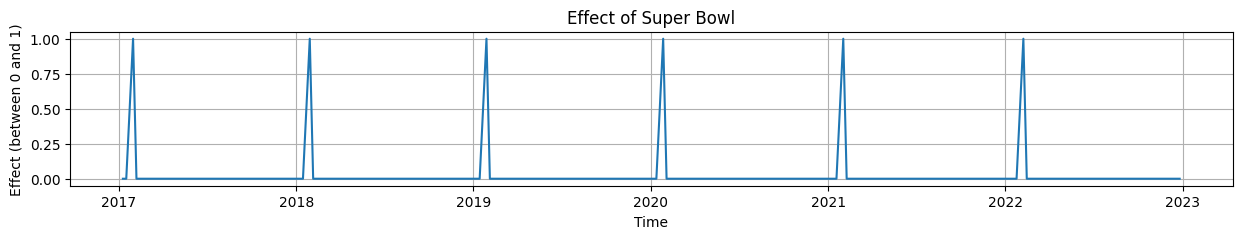

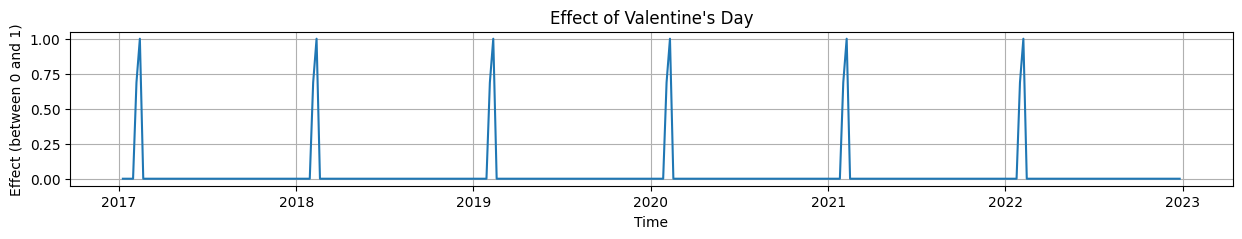

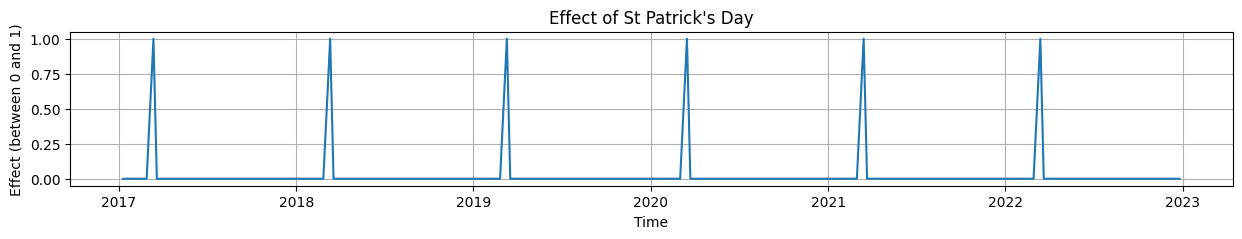

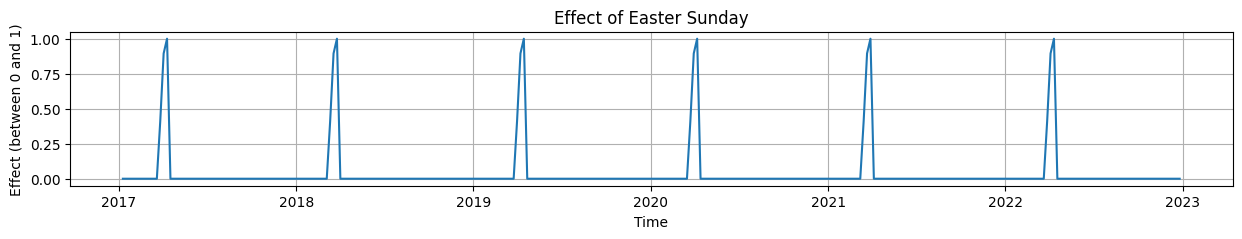

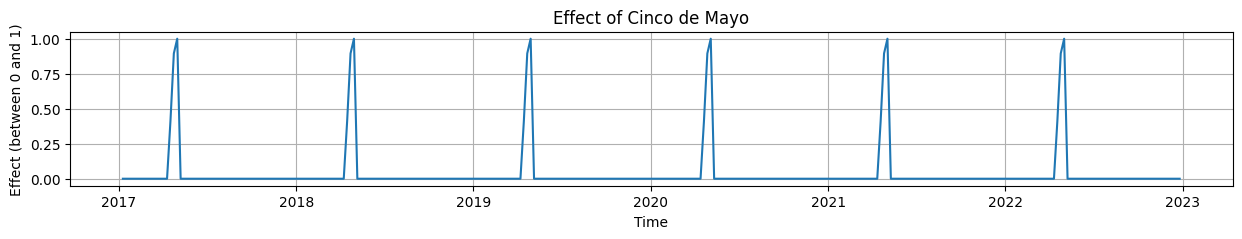

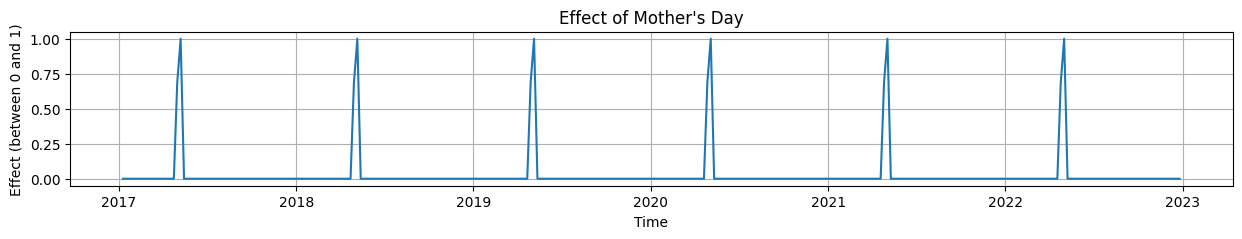

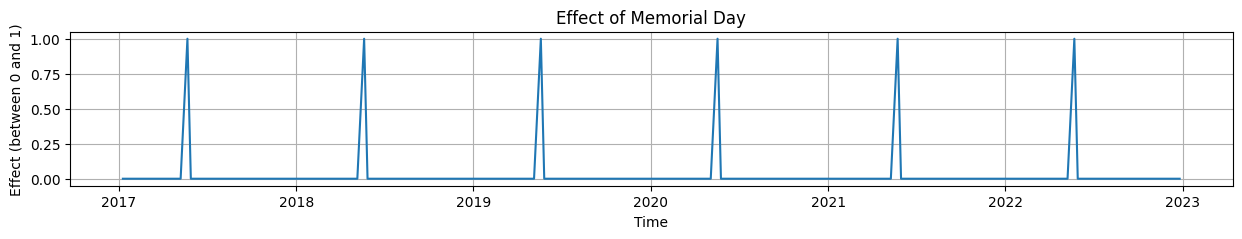

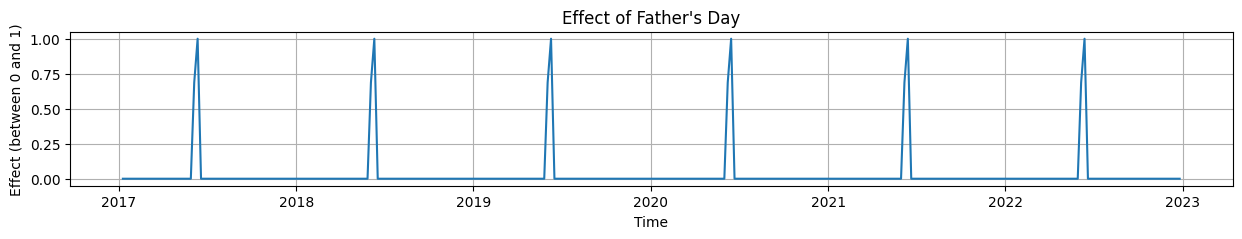

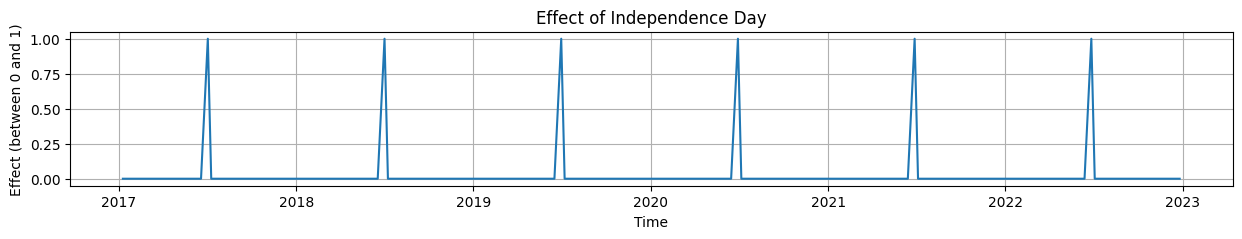

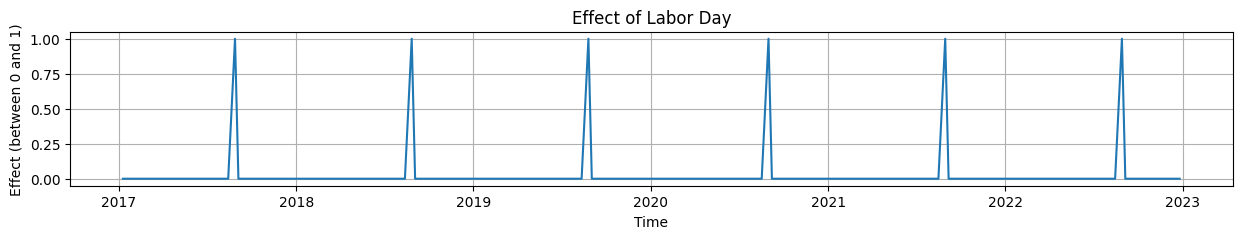

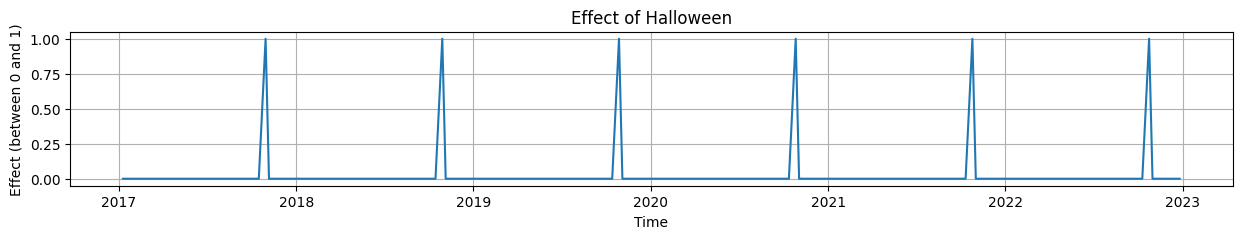

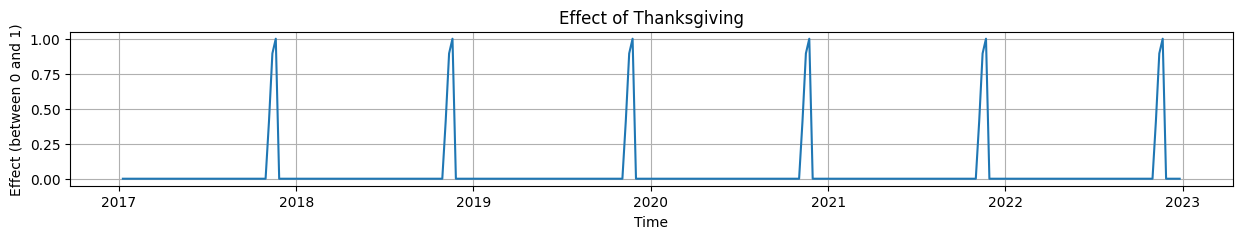

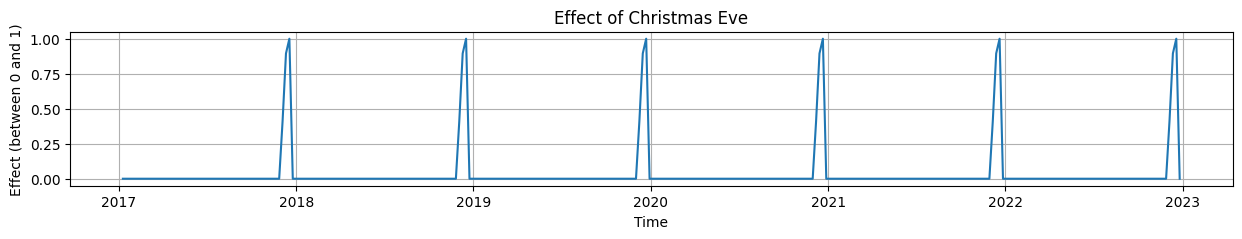

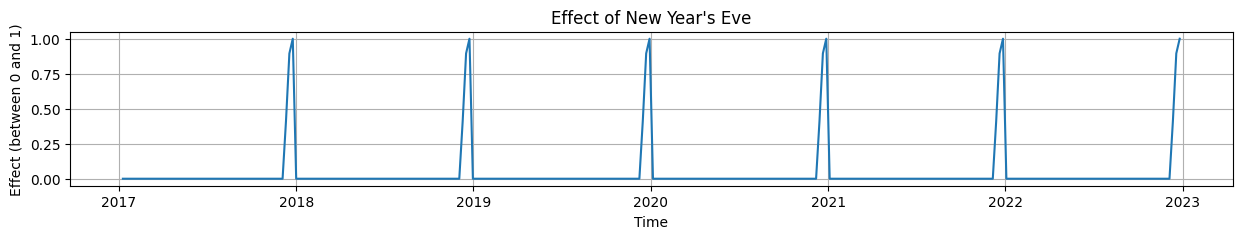


-------------------------



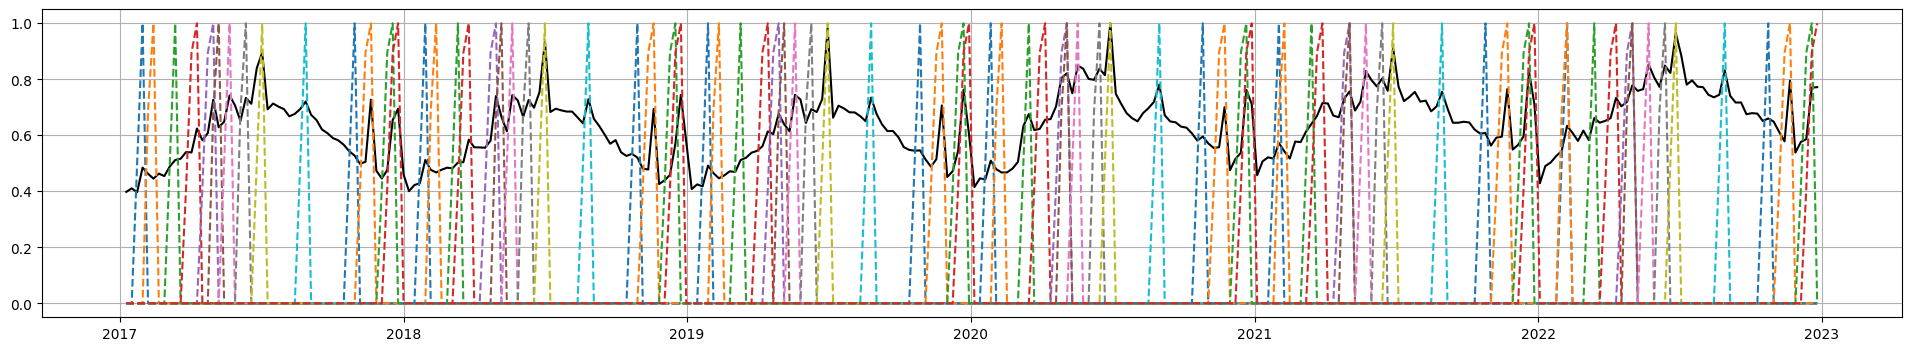

In [6]:
# Plot all the complete curves
series_events_dic, dfs_events_dic = generate_custom_events_series(
    events_series_base_params = events_series_base_params,
    delta_days_peak_effect_supp_target = 0, 
    delta_time_steps_before_peak_supp_target = 0,
    delta_time_steps_after_peak_supp_target = 0,
    curve_std_idx_supp_target = 0,
    time_series_start = train_start, 
    time_series_end = train_end,
    timestep_frequency = timestep_frequency,
    events_table_path = events_table_path,
    verbose = 1, 
    figsize = (15, 2)
)


print("\n-------------------------\n")

# Plot everything on the same graphs with the same magnitudes
df_target_analysis = df_target.copy(deep=True)

df_target_analysis.loc[:, "ds"] = df_target_analysis["ds"].apply(lambda s: pd.Timestamp(s))
df_target_analysis = df_target_analysis[df_target_analysis["ds"].apply(lambda ts: pd.Timestamp(train_start) <= ts <= pd.Timestamp(train_end))]
df_target_analysis = df_target_analysis.sort_values("ds")

max_ = round(max(df_target_analysis["y"]), 0)

plt.figure(figsize=(24, 4))
plt.plot(df_target_analysis['ds'], df_target_analysis['y'].apply(lambda x: x/max_), c="black")

for i, event in enumerate(series_events_dic):
    series_event = series_events_dic[event]
    plt.plot(series_event.index, series_event.values, label = event, ls='--')

plt.grid()
plt.show()

# Cross-Validation

Do the cross-valisation over all the combinations of event supp parameters x prophet cv parameters

In [7]:
# Combinations of prophet hyperparameters:
prophet_cv_params_combinations = [dict(zip(prophet_cv_params.keys(), v)) for v in itp(*prophet_cv_params.values())]
all_prophet_params_combinations = [{**prophet_fix_params, **cv_comb} for cv_comb in prophet_cv_params_combinations]

# Combinations of one event hyperparameters:
all_event_params_combinations = [dict(zip(event_params_cv_ranges.keys(), v)) for v in itp(*event_params_cv_ranges.values())]

# Init Dataset
df_target_cv = df_target.copy(deep=True)

df_target_cv.loc[:, "ds"] = df_target_cv["ds"].apply(lambda s: pd.Timestamp(s))
df_target_cv = df_target_cv[df_target_cv["ds"].apply(lambda ts: pd.Timestamp(train_start) <= ts <= pd.Timestamp(train_end))]
df_target_cv = df_target_cv.sort_values("ds")

# Cross-validation
rmses = []
models = []

for i in range(len(all_event_params_combinations)):

    series_events_dic, dfs_events_dic = generate_custom_events_series(
        events_series_base_params = events_series_base_params,
        delta_days_peak_effect_supp_target = all_event_params_combinations[i]["delta_days_peak_effect_supp"],
        delta_time_steps_before_peak_supp_target = all_event_params_combinations[i]["delta_time_steps_before_peak_supp"],
        delta_time_steps_after_peak_supp_target = all_event_params_combinations[i]["delta_time_steps_after_peak_supp"],
        curve_std_idx_supp_target = all_event_params_combinations[i]["curve_std_idx_supp"],
        time_series_start = train_start,
        time_series_end = train_end,
        timestep_frequency = timestep_frequency,
        events_table_path = events_table_path,
        verbose = 0
    )

    df_final = pd.concat(
        [df_target_cv.set_index('ds')] + \
        [dfs_events_dic[event].set_index('ds') for event in series_events_dic.keys()], 
        axis=1, join='inner'
    ).reset_index()


    for j in range(len(all_prophet_params_combinations)):

        model = Prophet(**all_prophet_params_combinations[j])
        
        # standardize must be at False to make sure non negative impact when the event does not occure
        for new_regressor in series_events_dic.keys():
            model.add_regressor(new_regressor, standardize=False)
        
        with suppress_stdout_stderr():
            model.fit(df_final)

        pred = model.predict(df_final)

        rmses.append(mean_squared_error(df_final["y"].values, pred["yhat"].values, squared=False))
        models.append(model)


    if (i+1) % 10 == 0:
        print("CV: {}/{} done".format(
            len(all_prophet_params_combinations) * (i+1),
            len(all_prophet_params_combinations) * len(all_event_params_combinations)
        ))

print("CV: {}/{} done\n".format(
    len(all_prophet_params_combinations) * len(all_event_params_combinations), 
    len(all_prophet_params_combinations) * len(all_event_params_combinations)
))


k_best = np.argmin(rmses) # We chose the best parameters based on rmses

i_best = k_best // len(all_prophet_params_combinations)
j_best = k_best % len(all_prophet_params_combinations)

print(f"k_best: {k_best}, i_best: {i_best}, j_best: {j_best}")

best_rmse = rmses[k_best]
best_model = models[k_best]

best_events_params = all_event_params_combinations[i_best]
best_prophet_params = all_prophet_params_combinations[j_best]

print(f"Best event params: {best_events_params}")
print(f"Best prophet params: {best_prophet_params}")

CV: 40/192 done
CV: 80/192 done
CV: 120/192 done
CV: 160/192 done
CV: 192/192 done

k_best: 99, i_best: 24, j_best: 3
Best event params: {'delta_days_peak_effect_supp': 0, 'delta_time_steps_before_peak_supp': 0, 'delta_time_steps_after_peak_supp': 0, 'curve_std_idx_supp': -1}
Best prophet params: {'growth': 'linear', 'changepoint_range': 0.85, 'weekly_seasonality': False, 'daily_seasonality': False, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 10, 'yearly_seasonality': 2, 'changepoint_prior_scale': 0.05}


# Training

rmse: 329209.783
mape: 0.046


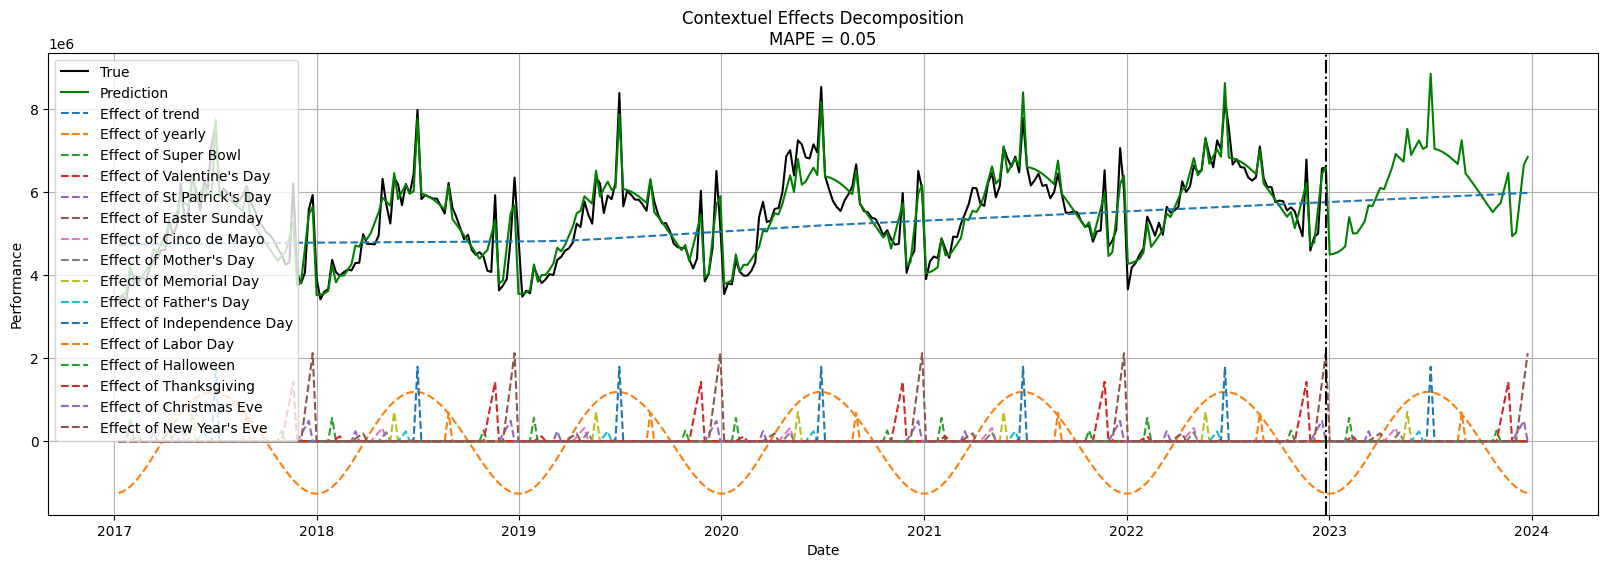

In [8]:
# 1) TRAINING OF THE BEST COMBINATION

series_events_dic, dfs_events_dic = generate_custom_events_series(
    events_series_base_params = events_series_base_params,
    delta_days_peak_effect_supp_target = best_events_params["delta_days_peak_effect_supp"],
    delta_time_steps_before_peak_supp_target = best_events_params["delta_time_steps_before_peak_supp"],
    delta_time_steps_after_peak_supp_target = best_events_params["delta_time_steps_after_peak_supp"],
    curve_std_idx_supp_target = best_events_params["curve_std_idx_supp"],
    time_series_start = train_start,
    time_series_end = train_end,
    timestep_frequency = timestep_frequency,
    events_table_path = events_table_path,
    verbose = 0
)

df_final = pd.concat(
    [df_target_cv.set_index('ds')] + \
    [dfs_events_dic[event].set_index('ds') for event in series_events_dic.keys()], 
    axis=1, join='inner'
).reset_index()

model = Prophet(**best_prophet_params)

# standardize must be at False to make sure non negative impact when the event does not occure
for new_regressor in series_events_dic.keys():
    model.add_regressor(new_regressor, standardize=False)

model.fit(df_final)


# 2) EVALUATION 

pred = model.predict(df_final)
rmse_model = mean_squared_error(df_final["y"].values, pred["yhat"].values, squared=False)
mape_model = mean_absolute_percentage_error(df_final["y"].values, pred["yhat"].values)

print("rmse:", round(rmse_model, 3))
print("mape:", round(mape_model, 3))


# 3) PREDICTION

prediction_input = pd.DataFrame(
    columns=['ds'],
    data=pd.date_range(
        start=train_start,
        end=forecast_end,
        freq=timestep_frequency
    )
)

series_events_dic_prediction, dfs_events_dic_prediction = generate_custom_events_series(
    events_series_base_params = events_series_base_params,
    delta_days_peak_effect_supp_target = best_events_params["delta_days_peak_effect_supp"],
    delta_time_steps_before_peak_supp_target = best_events_params["delta_time_steps_before_peak_supp"],
    delta_time_steps_after_peak_supp_target = best_events_params["delta_time_steps_after_peak_supp"],
    curve_std_idx_supp_target = best_events_params["curve_std_idx_supp"],
    time_series_start = train_start,
    time_series_end = forecast_end,
    timestep_frequency = timestep_frequency,
    events_table_path = events_table_path,
    verbose = 0
)

prediction_input = pd.concat(
    [prediction_input.set_index('ds')] + \
    [dfs_events_dic_prediction[event].set_index('ds') for event in series_events_dic_prediction.keys()], 
    axis=1, join='inner'
).reset_index()

best_model_predictions = model.predict(prediction_input)

best_model_predictions = best_model_predictions[
    ['ds', 'trend', 'yearly']
    + list(series_events_dic_prediction.keys())
    + ['yhat']
]

# Test to make sure that we have the complete decomposition of the sales time series in export data
test = np.allclose(
    best_model_predictions[[col for col in best_model_predictions.columns if col not in ["ds", "yhat"]]].sum(axis=1).to_numpy(),
    best_model_predictions["yhat"].to_numpy()
)
assert test


# 4) PLOT

plt.figure(figsize=(20, 6))
plt.plot(df_final["ds"], df_final['y'], c = 'black', label = "True")
plt.plot(best_model_predictions["ds"], best_model_predictions["yhat"], c = "green", label = "Prediction")
for col in [col for col in best_model_predictions.columns if col not in ["ds", "yhat"]]:
    plt.plot(best_model_predictions["ds"], best_model_predictions[col], label = "Effect of "+col, ls = '--')
plt.axvline(x = max(df_final["ds"]), c = 'black', ls='-.')

plt.grid()
plt.legend(loc='upper left')
plt.xlabel("Date")
plt.ylabel("Performance")
plt.title("Contextuel Effects Decomposition\nMAPE = {}".format(round(mape_model, 2)))

plt.savefig(images_path + "image.jpg")
plt.show()


# 5) SAVE FINAL CSV
best_model_predictions.to_csv(output_table_path, index=False)